In [77]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hem-3-folder/dataset/validation/no/aug_82_4270.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_3843.png
/kaggle/input/hem-3-folder/dataset/validation/no/173.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_0_6383.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_4961.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_61_630.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_40_2606.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_96_2781.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_29_4856.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_41_4007.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_27_152.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_98_2145.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_1_5807.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_13_4833.png
/kaggle/input/hem-3-folder/dataset/validation/no/162.png
/kaggle/input/hem-3-folder/dataset/validation

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [52]:
train_dir = "../input/hem-3-folder/dataset/train/"
validation_dir = "../input/hem-3-folder/dataset/validation/"
test_dir = "../input/hem-3-folder/dataset/test/"

In [53]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [54]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


1536 images loaded from ../input/hem-3-folder/dataset/train/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


480 images loaded from ../input/hem-3-folder/dataset/test/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

384 images loaded from ../input/hem-3-folder/dataset/validation/ directory.


In [55]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [56]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [57]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [58]:
input_shape = (224,224, 3)
batch_size = 32

In [59]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [60]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [69]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 64)       

In [70]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [71]:
# EPOCHS = 50

# history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator
# )


# EPOCHS = 200
EPOCHS = 50
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.6,
    patience=3,
    min_lr=1e-6,
    verbose=1)

# es = EarlyStopping(
#     monitor='val_accuracy', 
#     mode='max',
#     patience=6
# )
filename = 'custom6layer.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True
)

# history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])
history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, check_pt])


Epoch 1/50
48/48 [==============================] - 8s 142ms/step - loss: 0.6897 - accuracy: 0.5553 - val_loss: 0.6806 - val_accuracy: 0.6120

Epoch 00001: val_accuracy improved from -inf to 0.61198, saving model to custom6layer.h5
Epoch 2/50
48/48 [==============================] - 6s 133ms/step - loss: 0.6668 - accuracy: 0.5801 - val_loss: 0.6021 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.61198 to 0.75000, saving model to custom6layer.h5
Epoch 3/50
48/48 [==============================] - 7s 137ms/step - loss: 0.5698 - accuracy: 0.7109 - val_loss: 0.4489 - val_accuracy: 0.7891

Epoch 00003: val_accuracy improved from 0.75000 to 0.78906, saving model to custom6layer.h5
Epoch 4/50
48/48 [==============================] - 7s 137ms/step - loss: 0.4882 - accuracy: 0.7715 - val_loss: 0.4442 - val_accuracy: 0.7865

Epoch 00004: val_accuracy did not improve from 0.78906
Epoch 5/50
48/48 [==============================] - 6s 135ms/step - loss: 0.4378 - accuracy: 0.8151 

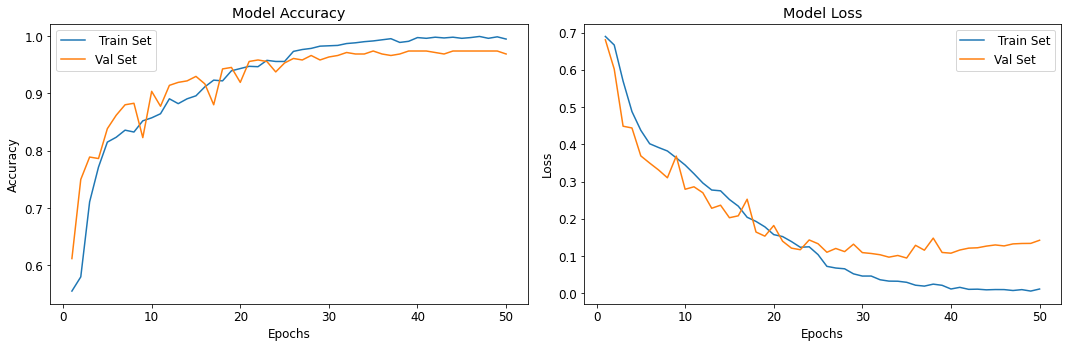

In [72]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [73]:
from tensorflow.keras.models import load_model
saved_model = load_model('./custom6layer.h5')

In [74]:
# validation
predictions = saved_model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9746, Val: 0.9479
Validation Accuracy = 0.9479
Precision: 0.930000
Recall: 0.968750
F1 score: 0.948980
Cohens kappa: 0.895833
ROC AUC: 0.947917
[[178  14]
 [  6 186]]
True positive: 186 , True negative: 178 , False positive: 14 , False negative: 6


Train: 0.9746, Test: 0.9604
Test Accuracy = 0.9604
Precision: 0.947368
Recall: 0.975000
F1 score: 0.960986
Cohens kappa: 0.920833
ROC AUC: 0.960417
[[227  13]
 [  6 234]]
True positive: 234 , True negative: 227 , False positive: 13 , False negative: 6
Sensitivity: 0.9750
Specificity: 0.9458


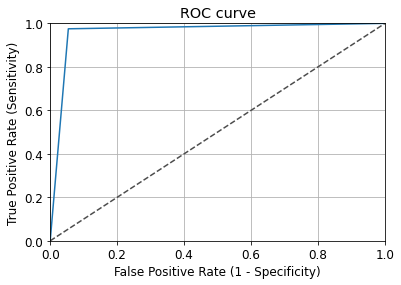

In [75]:
# test
predictions = saved_model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

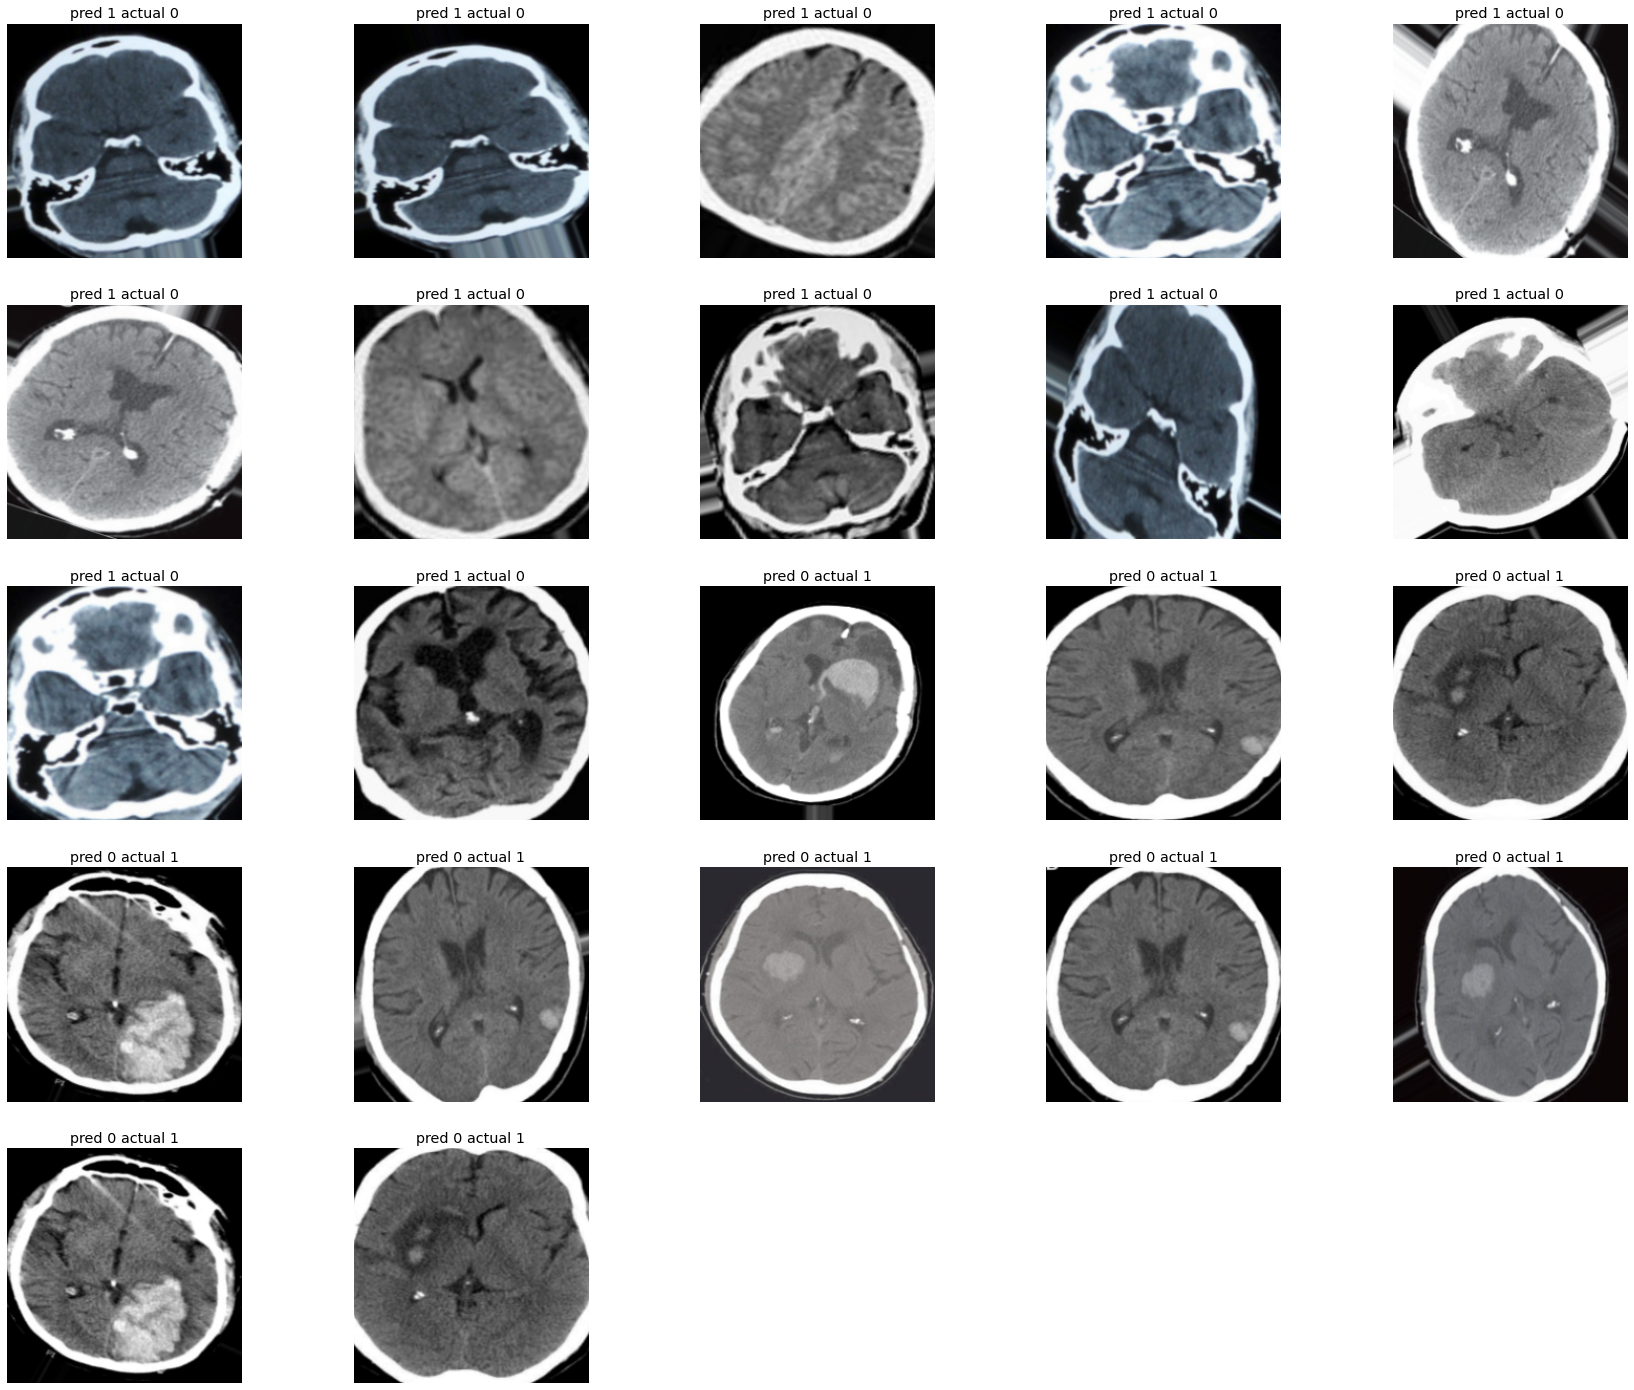

In [76]:
predicted = model.predict(X_test)
predicted = [1 if x>0.5 else 0 for x in predicted]
#print_images=True
#if print_images:
rows = 5
col = 5
j = 0
fig = plt.figure(figsize=(30, 25))

for i in range(len(predicted)):
    if predicted[i] != y_test[i]:
        j = j + 1
        fig.add_subplot(rows, col, j)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title("pred "+str(predicted[i])+" actual "+str(y_test[i]))
